### 1. Installing dependencies

In [24]:
!pip install gymnasium gym-anytrading pandas matplotlib stable-baselines3[extra] finta

### 2. importing packages

In [25]:
import gymnasium as gym
import gym_anytrading
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions

from stable_baselines3 import DQN, A2C, PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback

from gym_anytrading.envs import StocksEnv
from finta import TA

from sklearn.preprocessing import StandardScaler

### Constant

In [26]:
WINDOW_SIZE = 10
AMOUNT_OF_EPISODES = 50
INITIAL_CAPITAL = 1
DATASET_PATH = '/content/TESLA RL training data - 1 Sentiment 12.2024.csv'

### Methods

In [27]:
def calculate_calmar_ratio(initial_capital, final_capital, peak_value, trough_value, trading_days = 252):
    # Calculate the annualized return using trading days
    annualized_return = (final_capital / initial_capital) ** (252 / trading_days) - 1

    # Calculate the maximum drawdown
    max_drawdown = (peak_value - trough_value) / peak_value

    # Calculate the Calmar Ratio
    calmar_ratio = annualized_return / max_drawdown

    return calmar_ratio

### 3. Read the dataset and preprocess it

In [28]:
df = pd.read_csv(DATASET_PATH)

df['Date'] = pd.to_datetime(df.Date)

df.set_index('Date', inplace=True)

df.sort_index(inplace=True)

df.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)

df['Day'] = df.index.dayofweek

### Calculate technical indicators using finta  

In [29]:
df['SMA']      = TA.SMA(df, WINDOW_SIZE)
df['RSI']      = TA.RSI(df, WINDOW_SIZE)
df['MOM']      = TA.MOM(df, WINDOW_SIZE)
df['EMA']      = TA.EMA(df, WINDOW_SIZE)
df['AROONOSC'] = TA.AO(df,WINDOW_SIZE)

df.fillna(0, inplace=True)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
df.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Adj Close,Close,High,Low,Open,Volume,Sentiment,Predicted_Close,Day,SMA,RSI,MOM,EMA,AROONOSC
Date,,,,,,,,,,,,,,
2014-01-02,-1.599626,-1.599626,-1.609751,-1.606774,-1.604716,-0.191212,0,-1.531689,3,0.0,0.000000,0.0,-1.599626,0.0
2014-01-03,-1.608201,-1.608201,-1.614303,-1.573761,-1.601537,-0.530397,0,-1.566396,4,0.0,0.000000,0.0,-1.604342,0.0
2014-01-06,-1.648851,-1.648851,-1.642399,-1.627870,-1.601537,-0.379111,0,-1.551651,0,0.0,0.000000,0.0,-1.622234,0.0
2014-01-07,-1.611377,-1.611377,-1.642399,-1.627709,-1.639363,-0.453380,0,-1.581032,1,0.0,46.261635,0.0,-1.618657,0.0
2014-01-08,-1.580889,-1.580889,-1.590601,-1.571184,-1.619814,-0.196936,0,-1.576943,2,0.0,62.107716,0.0,-1.607815,0.0


### Trading Environment

In [31]:
class MyCustomEnv(StocksEnv):

  def __init__(self, df, window_size, frame_bound, **kwargs):
    super().__init__(df, window_size, frame_bound, **kwargs)

  def reset(self, seed=None, options=None):
    self._truncated = False
    self._current_tick = self._start_tick
    self._last_trade_tick = self._current_tick - 1
    self._position = Positions.Short
    self._position_history = (self.window_size * [None]) + [self._position]
    self._total_reward = INITIAL_CAPITAL
    self._total_profit = INITIAL_CAPITAL
    self._first_rendering = True
    self.history = {}

    observation = self._get_observation()
    info = self._get_info()

    if self.render_mode == 'human':
        self._render_frame()

    return observation, info

  def _process_data(self):
    start = self.frame_bound[0] - self.window_size
    #print('env',env._position)
    end = self.frame_bound[1]
    prices = self.df.loc[:, 'Close'].to_numpy()[start:end]
    diff = np.insert(np.diff(prices), 0, 0)

    self.df['Close_lag1'] = self.df['Close'].shift(1)
    self.df['RSI_lag1'] = self.df['RSI'].shift(1)

    signal_features = self.df.loc[:, ['Close','Sentiment','Predicted_Close','SMA', 'RSI', 'MOM', 'EMA', 'AROONOSC', "Close_lag1", "RSI_lag1"]].to_numpy()[start:end]
    # Reshape diff to (282, 1)
    diff_reshaped = diff.reshape(len(diff), 1)

    # Concatenate along the second axis (columns)
    scaler = StandardScaler()
    signal_features = scaler.fit_transform(signal_features)

    return prices, signal_features

  def _is_trade_possible(self, action):
    possible_trade_flag = (
        (action == Actions.Buy.value and self._position == Positions.Short) or
        (action == Actions.Sell.value and self._position == Positions.Long)
    )

    return possible_trade_flag

  def _calculate_reward(self, action):
    step_reward = 0

    if self._is_trade_possible(action):
      current_price = self.prices[self._current_tick]
      last_trade_price = self.prices[self._last_trade_tick]
      price_diff = current_price - last_trade_price

      if self._position == Positions.Long:
        step_reward = price_diff
      else:
        step_reward = -price_diff

    return step_reward

  def _update_profit(self, action):
    trade = self._is_trade_possible(action)

    if trade or self._truncated:
      current_price = self.prices[self._current_tick]
      last_trade_price = self.prices[self._last_trade_tick]

      if self._position == Positions.Long:
        price_change = current_price - last_trade_price
        self._total_profit += price_change - (current_price * self.trade_fee_bid_percent)

      elif self._position == Positions.Short:
        price_change = last_trade_price - current_price
        self._total_profit += price_change - (current_price * self.trade_fee_ask_percent)


  def step(self, action):
    self._truncated = False
    self._current_tick += 1

    if self._current_tick == self._end_tick:
        self._truncated = True

    step_reward = self._calculate_reward(action)
    self._total_reward += step_reward

    self._update_profit(action)

    trade = self._is_trade_possible(action)

    if trade:
        self._position = self._position.opposite()
        self._last_trade_tick = self._current_tick

    self._position_history.append(self._position)
    observation = self._get_observation()
    info = self._get_info()
    self._update_history(info)

    if self.render_mode == 'human':
        self._render_frame()

    return observation, step_reward, False, self._truncated, info

  def render_all(self, title=None):
    window_ticks = np.arange(len(self._position_history))
    plt.plot(self.prices, color='black')

    short_ticks = []
    long_ticks = []
    for i, tick in enumerate(window_ticks):
        if self._position_history[i] == Positions.Short:
            short_ticks.append(tick)
        elif self._position_history[i] == Positions.Long:
            long_ticks.append(tick)

    plt.scatter(long_ticks, self.prices[long_ticks], color="green", marker='^')
    plt.scatter(short_ticks, self.prices[short_ticks], color="red", marker='v')

    plt.axvline(x=0, color='blue', linestyle='dotted', linewidth=1, label='Look Back Window Area')
    plt.axvline(x=WINDOW_SIZE, color='blue', linestyle='dotted', linewidth=1)

    plt.title(f"Trading Behaviour - Look Back Window of {WINDOW_SIZE} Days")

    plt.xlabel('Time Steps')
    plt.ylabel('Normalised Stock Price')

    plt.grid()
    plt.legend(["Normalised Stock Price", "Buy", "Sell", "Initial Look Back Window"], loc='upper left', framealpha=1)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Dataset split

In [32]:
split_date = '2019-01-01'

train_df = df.loc[df.index < split_date]
test_df = df.loc[df.index >= split_date]

print('train_df: ',len(train_df))
print('test_df: ',len(test_df))

train_df:  1258
test_df:  252


In [33]:
env = MyCustomEnv(df=train_df, frame_bound=(WINDOW_SIZE, len(train_df)), window_size=WINDOW_SIZE)

<ipython-input-31-b1eed62fa445>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Close_lag1'] = self.df['Close'].shift(1)
<ipython-input-31-b1eed62fa445>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['RSI_lag1'] = self.df['RSI'].shift(1)


In [34]:
env.signal_features[:1,:]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[-1.9628626 , -0.01111891, -1.91076118, -0.15035288, -3.43478845,
        -0.06161102, -1.98503502, -0.04984711,         nan,         nan]])

In [35]:
env.action_space

Discrete(2)

Discrete: describes a discrete space where {0, 1, …, n-1} are the possible values our observation or action can take. Values can be shifted to {a, a+1, …, a+n-1} using an optional argument.

In [36]:
env.action_space.sample()

0

Sell = 0

Buy = 1

In [37]:
env.observation_space

Box(-10000000000.0, 10000000000.0, (10, 10), float32)

Box: describes an n-dimensional continuous space. It’s a bounded space where we can define the upper and lower limits which describe the valid values our observations can take.



In [38]:
env.observation_space.sample()

array([[-6.8941778e+09,  2.4886674e+09,  3.4295621e+09, -6.7483174e+08,
        -5.0497039e+09, -3.2910227e+08, -7.8659169e+09, -9.4032916e+09,
        -4.1121167e+09, -2.5884252e+09],
       [-5.4746552e+09, -9.0934077e+09,  5.5569830e+08, -4.4984765e+09,
         6.0427249e+09, -9.3288366e+09,  4.3710356e+09,  8.3507123e+09,
        -8.7985439e+09, -3.4658790e+09],
       [ 5.9996006e+09,  9.3058867e+09, -1.3466476e+09, -2.0755297e+09,
         5.6111478e+09,  2.6869270e+08,  1.4879045e+09,  7.1599642e+09,
        -6.1665976e+09, -4.7127967e+09],
       [-6.8004536e+09, -4.4300518e+09,  8.5515643e+09, -1.6325834e+09,
        -1.5056699e+09, -2.0973654e+09,  2.8610260e+09, -6.9780311e+09,
        -5.1669939e+09,  2.5863270e+09],
       [ 7.0228004e+09,  8.8388557e+09, -7.5389382e+08,  5.2338094e+09,
        -7.3762079e+09, -2.6448817e+09, -5.0865833e+09,  1.3932550e+09,
        -8.3659162e+09,  4.2669862e+09],
       [-3.5755860e+09, -4.3845811e+09,  6.0295020e+09,  4.9257964e+09,
   

### 4. Create the environment and do some random action on it

info: {'total_reward': 1.5309902431393283, 'total_profit': 1.0818480016670478, 'position': <Positions.Long: 1>}


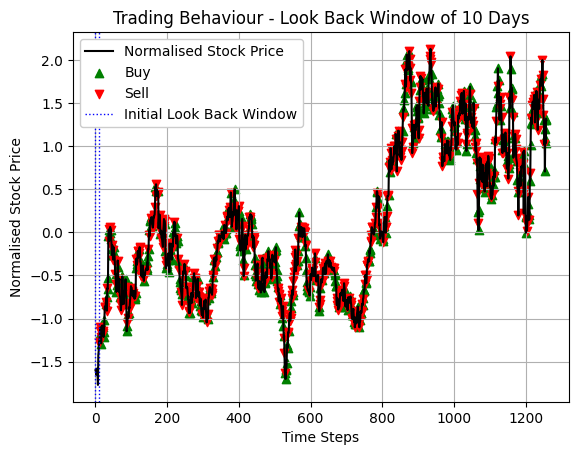

In [39]:
observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

### 5 creating and training the model

In [40]:
model = A2C("MlpPolicy", env, verbose=1)

amount_of_timesteps = AMOUNT_OF_EPISODES * len(train_df)
print('amount_of_timesteps',amount_of_timesteps)

model.learn(total_timesteps=amount_of_timesteps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
amount_of_timesteps 62900
------------------------------------
| time/                 |          |
|    fps                | 215      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.69    |
|    explained_variance | -5.89    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.14    |
|    value_loss         | 0.0613   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 246      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.602   |
|    explained_variance | -5.36    |
|    learning_rate      | 0.0

### Evaluate model

<ipython-input-31-b1eed62fa445>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Close_lag1'] = self.df['Close'].shift(1)
<ipython-input-31-b1eed62fa445>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['RSI_lag1'] = self.df['RSI'].shift(1)


info: {'total_reward': 3.944918998166855, 'total_profit': 2.4438538930820144, 'position': <Positions.Short: 0>}
peak_value 4.117413080534668
tough_value 1.0
calmar_ratio 1.9070115997387078


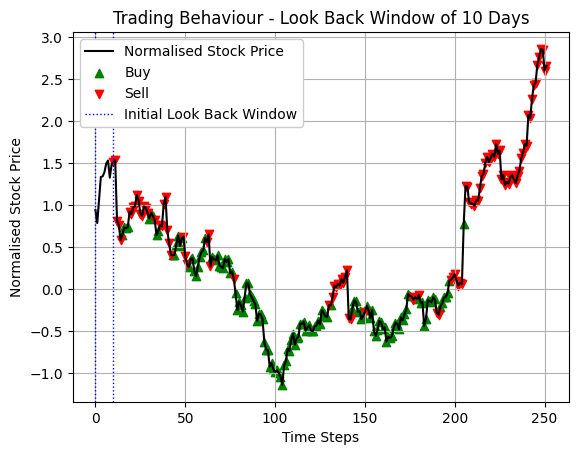

<ipython-input-31-b1eed62fa445>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Close_lag1'] = self.df['Close'].shift(1)
<ipython-input-31-b1eed62fa445>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['RSI_lag1'] = self.df['RSI'].shift(1)


info: {'total_reward': 4.393659975654826, 'total_profit': 2.8877838931763504, 'position': <Positions.Short: 0>}
peak_value 4.576110609395328
tough_value 1.0
calmar_ratio 2.415671338328823


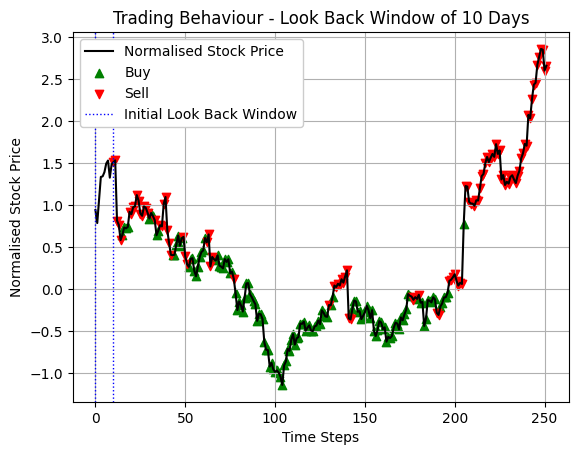

<ipython-input-31-b1eed62fa445>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Close_lag1'] = self.df['Close'].shift(1)
<ipython-input-31-b1eed62fa445>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['RSI_lag1'] = self.df['RSI'].shift(1)


info: {'total_reward': 4.111330593631138, 'total_profit': 2.6094334305689726, 'position': <Positions.Short: 0>}
peak_value 4.282992618021626
tough_value 1.0
calmar_ratio 2.0996670734148823


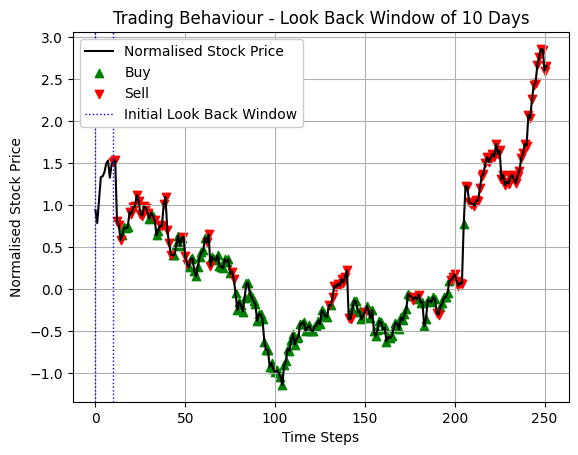

<ipython-input-31-b1eed62fa445>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Close_lag1'] = self.df['Close'].shift(1)
<ipython-input-31-b1eed62fa445>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['RSI_lag1'] = self.df['RSI'].shift(1)


info: {'total_reward': 4.152615708507419, 'total_profit': 2.645397937765188, 'position': <Positions.Short: 0>}
peak_value 4.318957125217842
tough_value 1.0
calmar_ratio 2.14115545305915


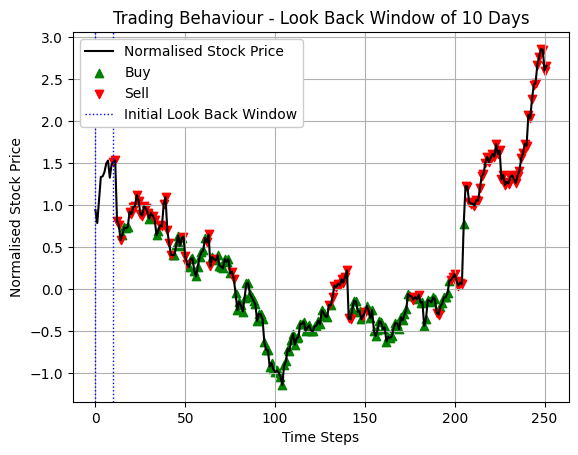

<ipython-input-31-b1eed62fa445>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Close_lag1'] = self.df['Close'].shift(1)
<ipython-input-31-b1eed62fa445>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['RSI_lag1'] = self.df['RSI'].shift(1)


info: {'total_reward': 5.624599326634015, 'total_profit': 4.126485335404359, 'position': <Positions.Short: 0>}
peak_value 5.57206824017794
tough_value 1.0
calmar_ratio 3.810308316857208


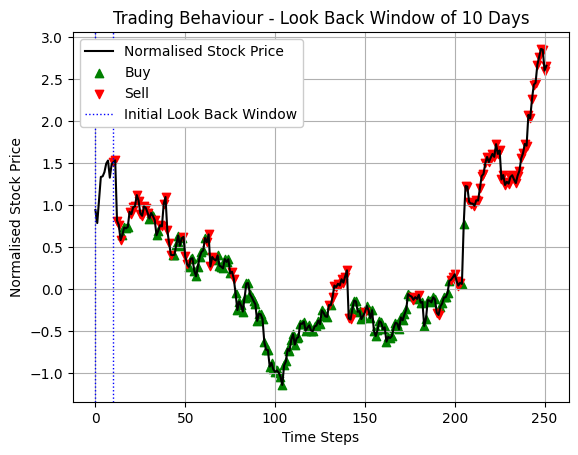

In [41]:
calmar_ratio_list = []
total_reward_list = []
total_profit_list = []

for i in range(5):
  env = MyCustomEnv(df=test_df, frame_bound=(WINDOW_SIZE, len(test_df)), window_size=WINDOW_SIZE)

  observation, info = env.reset()
  while True:
      action = model.predict(observation)
      observation, reward, terminated, truncated, info = env.step(action[0])
      done = terminated or truncated

      if done:
          print("info:", info)
          peak_value = np.max(env.history['total_profit'])
          tough_value = np.min(env.history['total_profit'])
          final_capital = info['total_profit']
          print('peak_value',peak_value)
          print('tough_value',tough_value)
          calmar_ratio = calculate_calmar_ratio(INITIAL_CAPITAL,final_capital,peak_value,tough_value)
          print('calmar_ratio',calmar_ratio)
          calmar_ratio_list.append(calmar_ratio)
          total_reward_list.append(info['total_reward'])
          total_profit_list.append(info['total_profit'])
          break

  plt.cla()
  env.unwrapped.render_all()
  plt.show()

In [42]:
calmar_ratio_list

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[1.9070115997387078,
 2.415671338328823,
 2.0996670734148823,
 2.14115545305915,
 3.810308316857208]

In [43]:
print('Average Calmar Ratio: ', np.mean(calmar_ratio_list))
print('Average Total Reward: ', np.mean(total_reward_list))
print('Average Total Profit: ', np.mean(total_profit_list))

Average Calmar Ratio:  2.4747627562797545
Average Total Reward:  4.445424920518851
Average Total Profit:  2.9425908979993767


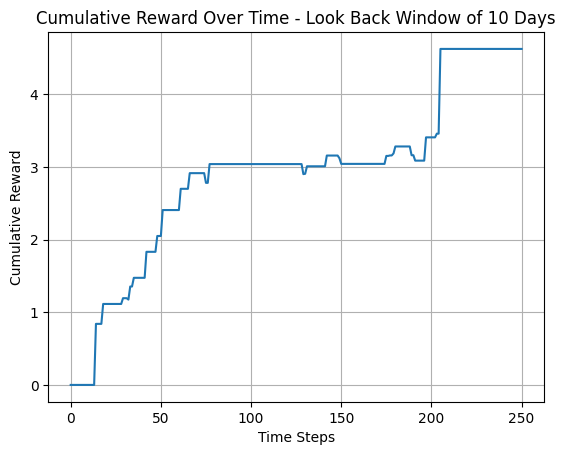

In [44]:
total_reward_list = [0] * WINDOW_SIZE
agent_reward_list = [reward - INITIAL_CAPITAL for reward in env.history['total_reward']]

total_reward_list.extend(agent_reward_list)

plt.plot(total_reward_list)
plt.title(f"Cumulative Reward Over Time - Look Back Window of {WINDOW_SIZE} Days")

plt.xlabel('Time Steps')
plt.ylabel('Cumulative Reward')

plt.grid()
plt.show()